In [1]:
import numpy as np   
import numpy.random as npr 
import matplotlib.pyplot as plt 
from scipy.stats import norm
from numpy.polynomial.laguerre import lagval
from sklearn.linear_model import LinearRegression

In [2]:
npr.seed(123)

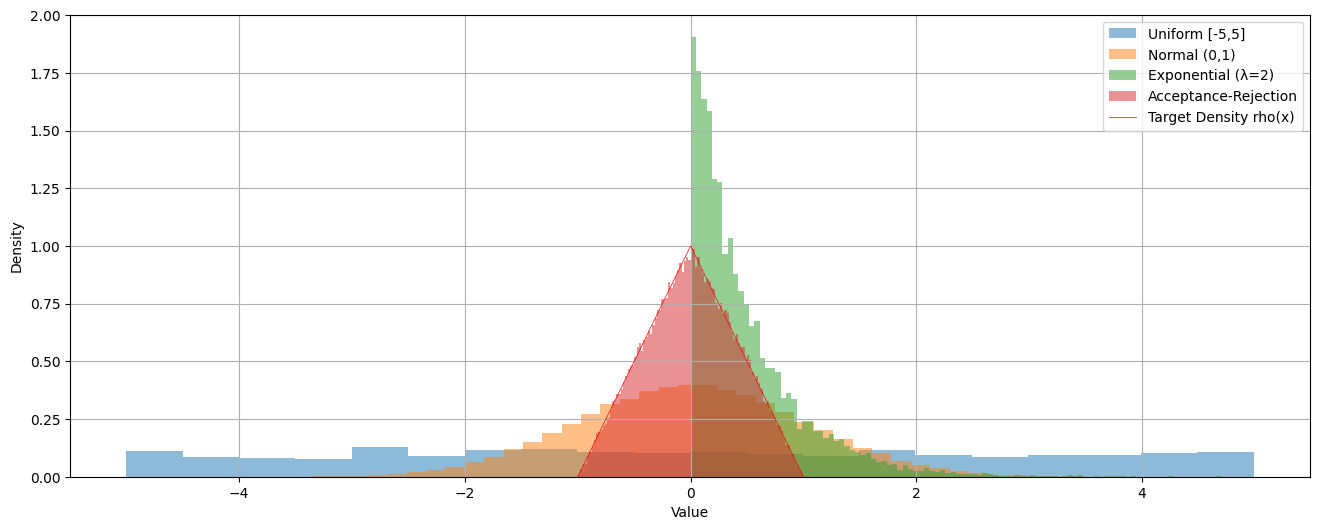

In [3]:
X = npr.random(1000) # U(0,1)
Y = npr.random(1000)  # X and Y are independent

U = 10 * X - 5 # scaled and shifted U(-5,5)

G = npr.normal(0, 1, 100000)

# Simulating exponential r.v
lam = 2
U_exp = npr.random(10000)
X_exp = -1 / lam * np.log(1 - U_exp)  # Exponential sample

# Acceptance-Rejection method for a custom density
def rho(x):
    return 1 - abs(x) if -1 <= x <= 1 else 0

N = 100000
j = 0
Z = np.zeros(N)

while j < N:
    X_ar = 2 * npr.random(1) - 1  # Uniform r.v. in [-1,1]
    Y_ar = npr.random(1)  # Uniform r.v. in [0,1], independent
    if rho(X_ar) > Y_ar:
        Z[j] = X_ar
        j += 1

plt.figure(figsize=(16, 6))
plt.hist(U, bins=20, density=True, alpha=0.5, label="Uniform [-5,5]")
plt.hist(G, bins=50, density=True, alpha=0.5, label="Normal (0,1)")
plt.hist(X_exp, bins=100, density=True, alpha=0.5, label="Exponential (λ=2)")
plt.hist(Z, bins=100, density=True, alpha=0.5, label="Acceptance-Rejection")
x_vals = np.linspace(-1, 1, 1000)
y_vals = [rho(x) for x in x_vals]
plt.plot(x_vals, y_vals, 'r-', linewidth=.5, label="Target Density rho(x)")


plt.legend()
plt.xlabel("Value")
plt.ylabel("Density")
plt.grid(True)
plt.show()


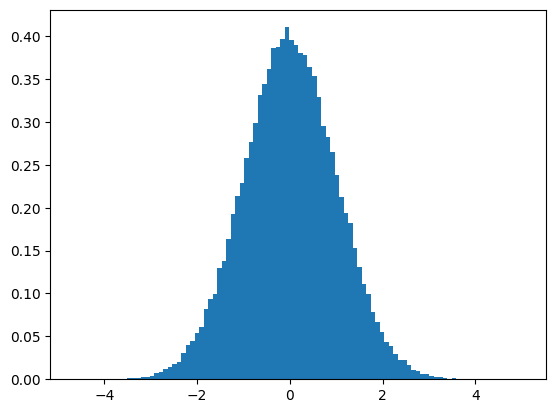

In [4]:
#Box-Muller
N=100000

U=npr.random(int(N/2)) # uniform [0,1]
V=npr.random(int(N/2))


X=np.sqrt(-2*np.log(U))*np.cos(2*np.pi*V)
 
Y=np.sqrt(-2*np.log(U))*np.sin(2*np.pi*V)

Z=np.concatenate((X,Y))

plt.hist(Z,bins=100,density=True)    
plt.show()


0.8660254037844386
[[1.        0.       ]
 [0.5       0.8660254]]


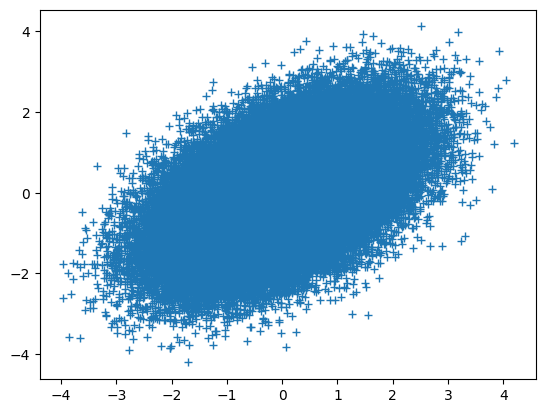

In [5]:
npr.normal(0,1,size=(4,1000))

# Generate A gaussian vector with a given Covariance matrix Gamma
rho=0.5

Gamma=np.array(([1,rho],[rho,1]))

# Cholesky transform 
A=np.linalg.cholesky(Gamma)
print(np.sqrt(1-rho**2))

print(A)

# Generate a 2xN matrix of independent standard normal r.v. 
N=100000
X=npr.normal(0,1,size=(2,N))

# Get the correlated idependent copies of (X_1,X_2) 

G=np.dot(A,X)


plt.plot(G[0,:],G[1,:],'+')
plt.show()

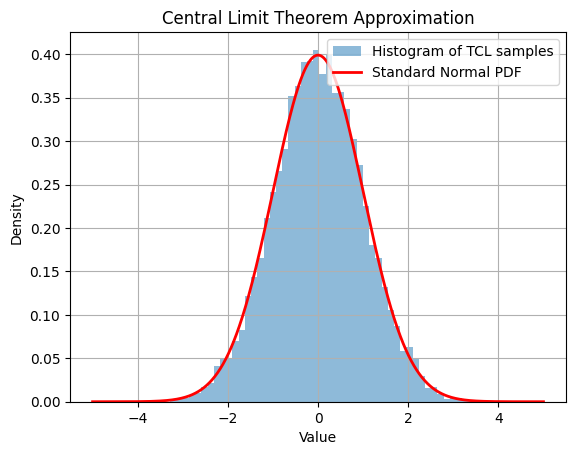

In [6]:
def tcl(n, p, nc):
    
    X = np.random.rand(n, p)
    
    Z = np.sqrt(12 / p) * (np.sum(X, axis=1) - p / 2)
    
    plt.hist(Z, bins=nc, density=True, alpha=0.5, label="Histogram of TCL samples")
    
    C = np.linspace(-5, 5, 1000)
    plt.plot(C, np.exp(-C**2 / 2) / np.sqrt(2 * np.pi), 'r-', linewidth=2, label="Standard Normal PDF")
    
    plt.xlabel("Value")
    plt.ylabel("Density")
    plt.title("Central Limit Theorem Approximation")
    plt.legend()
    plt.grid(True)
    plt.show()

tcl(n=10000, p=30, nc=50)


[0.00333333]


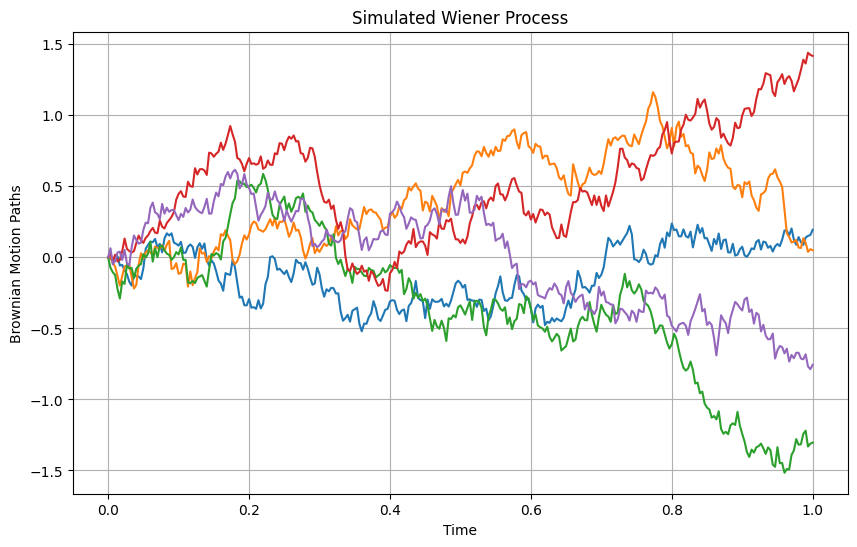

In [7]:
m = 5  # nb BM paths
n = 300  # nbtime steps

# Time discretization
t = np.linspace(0, 1, n + 1).reshape(-1, 1)
# h = np.diff(t[:2])[0]  # Step size
h = t[1] - t[0]
print(h)
# Brownian increments (dW ~ Normal(0, h))
dw = np.sqrt(h) * np.random.randn(n, m)

# BM paths (cumulative sum)
w = np.vstack([np.zeros((1, m)), np.cumsum(dw, axis=0)])

plt.figure(figsize=(10, 6))
plt.plot(t, w, lw=1.5)
plt.xlabel("Time")
plt.ylabel("Brownian Motion Paths")
plt.title("Simulated Wiener Process")
plt.grid(True)
plt.show()

In [8]:

def black_scholes(S0, K, T, r, sigma, option_type="call"):
    
    # explicit formula for european-style options..
    d1 = (np.log(S0 / K) + (r + (sigma ** 2) / 2) * T) / (sigma * np.sqrt(T)) #T maturity in years
    d2 = d1 - sigma * np.sqrt(T)

    if option_type == "call":
        price = S0 * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)
    elif option_type == "put":
        price = K * np.exp(-r * T) * norm.cdf(-d2) - S0 * norm.cdf(-d1)
    else:
        raise ValueError("Invalid option type. Choose 'call' or 'put'.")

    return price

call_price = black_scholes(100, 100, 1, .05, .2, option_type="call")
put_price = black_scholes(100, 100, 1, .05, .2, option_type="put")

print(f"Call Option Price: {call_price:.2f}")
print(f"Put Option Price: {put_price:.2f}")



Call Option Price: 10.45
Put Option Price: 5.57


In [9]:
def monte_carlo_option(S0, K, T, r, sigma, option_type="call", num_simulations=100000):

    Z = np.random.randn(num_simulations) 
    S_T = S0 * np.exp((r - 0.5 * sigma**2) * T + sigma * np.sqrt(T) * Z)

    if option_type == "call":
        payoffs = np.maximum(S_T - K, 0) 
    elif option_type == "put":
        payoffs = np.maximum(K - S_T, 0) 
    else:
        raise ValueError("Invalid option type. Choose 'call' or 'put'.")

    # Discount payoffs back to present
    option_price = np.exp(-r * T) * np.mean(payoffs)
    
    return option_price

call_price = monte_carlo_option(100, 100, 1, .05, .2, option_type="call")
put_price = monte_carlo_option(100, 100, 1, .05, .2, option_type="put")

print(f"Call Option Price: {call_price:.2f}")
print(f"Put Option Price: {put_price:.2f}")


Call Option Price: 10.37
Put Option Price: 5.57


#### path-dependent options 


In [10]:
def MC_asian_option(S0, K, T, r, sigma, option_type="call", num_simulations=100000, num_steps=252): #nb steps for averaging 

    dt = T / num_steps
    Z = np.random.randn(num_simulations, num_steps) 
    S = np.zeros((num_simulations, num_steps + 1))
    S[:, 0] = S0
    for t in range(1, num_steps + 1):
        S[:, t] = S[:, t - 1] * np.exp((r - 0.5 * sigma**2) * dt + sigma * np.sqrt(dt) * Z[:, t - 1])

    A = np.mean(S[:, 1:], axis=1) #avg except S_0
    if option_type == "call":
        payoffs = np.maximum(A - K, 0)
    else:
        payoffs = np.maximum(K - A, 0)
    price = np.exp(-r * T) * np.mean(payoffs)

    return price

In [11]:
asian_call_price = MC_asian_option(S0=100, K=100, T=1, r=0.05, sigma=0.2, option_type="call")
asian_put_price = MC_asian_option(S0=100, K=100, T=1, r=0.05, sigma=0.2, option_type="put")


In [12]:
print(f"Asian Call Option Price: {asian_call_price:.2f}")
print(f"Asian Put Option Price: {asian_put_price:.2f}")

Asian Call Option Price: 5.81
Asian Put Option Price: 3.33


    * examining Least squares using MC

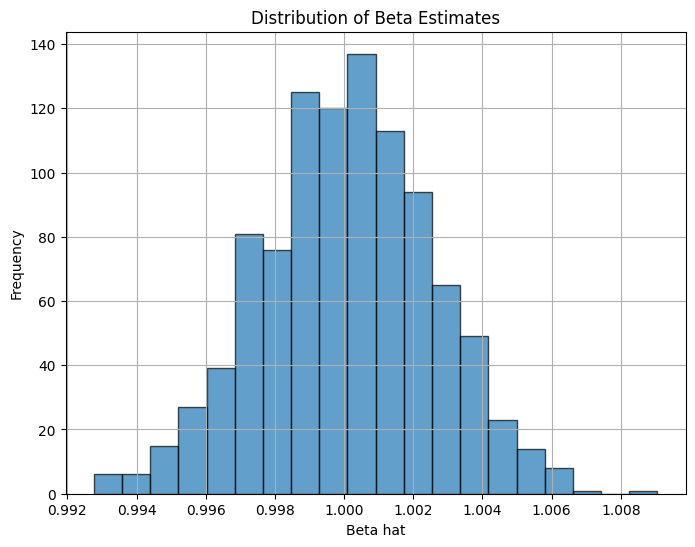

In [13]:
alpha = 1
beta = 1

n = 10000
m = 1000
beta_hat = np.zeros(m)
for i in range(m):
    
    x = 4 * np.random.randn(n, 1) #  x ~ N(0, 16) 
    e = np.random.randn(n, 1) #e ~ N(0, 1)

    y = alpha + beta * x + e

    X = np.hstack((np.ones((n, 1)), x))

    beta_hat_vec = np.linalg.inv(X.T @ X) @ X.T @ y

    beta_hat[i] = beta_hat_vec[1]

plt.figure(figsize=(8, 6))
plt.hist(beta_hat, bins=20, edgecolor="black", alpha=0.7)
plt.xlabel("Beta hat")
plt.ylabel("Frequency")
plt.title("Distribution of Beta Estimates")
plt.grid(True)
plt.show()


* beta_hat converges to beta
* LS has minimal variance under Gauss-Markov assumptions
* with bigger n the hist becomes skewed or biased, something might be wrong with the assumptions ( non-normal errors)??

In [14]:

def MC_american_option(S0, K, T, r, sigma, option_type="call", num_simulations=100000, num_steps=50):


    dt = T / num_steps
    discount = np.exp(-r * dt)

    Z = np.random.randn(num_simulations, num_steps)
    S = np.zeros((num_simulations, num_steps + 1))
    S[:, 0] = S0

    for t in range(1, num_steps + 1):
        S[:, t] = S[:, t - 1] * np.exp((r - 0.5 * sigma**2) * dt + sigma * np.sqrt(dt) * Z[:, t - 1])

    if option_type == "call":
        payoffs = np.maximum(S[:, 1:] - K, 0)
    else:
        payoffs = np.maximum(K - S[:, 1:], 0)

    # Backward induction
    option_values = np.copy(payoffs[:, -1])
    
    for t in range(num_steps - 1, 0, -1):
        in_the_money = payoffs[:, t] > 0
        X = S[in_the_money, t]  # Stock prices where exercise is possible
        Y = option_values[in_the_money] * discount  # Discounted future values

        if len(X) > 0:
            # Fit regression (using Laguerre polynomials)
            X_poly = np.column_stack([X**i for i in range(3)])
            model = LinearRegression().fit(X_poly, Y)

            # Predict continuation values
            continuation_values = model.predict(X_poly)
            exercise_values = payoffs[in_the_money, t]

            # Exercise if immediate exercise is better
            exercise_now = exercise_values > continuation_values
            option_values[in_the_money] = np.where(exercise_now, exercise_values, option_values[in_the_money] * discount)

    # Discount final option value
    return np.mean(option_values) * discount




In [15]:
american_call_price = MC_american_option(S0=100, K=100, T=1, r=0.05, sigma=0.2, option_type="call")
american_put_price = MC_american_option(S0=100, K=100, T=1, r=0.05, sigma=0.2, option_type="put")

print(f"American Call Option Price: {american_call_price:.2f}")
print(f"American Put Option Price: {american_put_price:.2f}")

American Call Option Price: 6.61
American Put Option Price: 4.94
